### Problem Statement

- Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

- By using given and created features of users we can give user based similarity.

- Similarly by using the features of films mainly genres we can show similar movies with respect to particular movie.


### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#loading data
movies = pd.read_fwf('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/zee-users.dat', encoding='ISO-8859-1')

In [ ]:
movies.columns, ratings.columns, users.columns

(Index(['Movie ID::Title::Genres', 'Unnamed: 1', 'Unnamed: 2'], dtype='object'),
 Index(['UserID::MovieID::Rating::Timestamp'], dtype='object'),
 Index(['UserID::Gender::Age::Occupation::Zip-code'], dtype='object'))

In [ ]:
delimiter = '::'

#Expanding columns
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'])
movies = movies['Movie ID::Title::Genres'].str.split(delimiter,expand=True)
movies.columns = ['MovieID','Title','Genres']


ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter,expand=True)
ratings.columns = ['UserID','MovieID','Rating','Timestamp']

users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter,expand=True)
users.columns = ['UserID','Gender','Age','Occupation','Zip-code']

In [ ]:
movie = movies.copy()
rating = ratings.copy()
user = users.copy()

### EDA

In [ ]:
movies['Genres'].fillna(method='ffill',inplace = True)
movies.loc[(movies.Genres==''),'Genres'] = ['Drama']*2
movies['release_year'] = movies['Title'].str[-5:-1]
movies.loc[~(movies['release_year'].str.contains(r'\d{4}')),'release_year']=[1996]*23

In [ ]:
movies['MovieID'] = movies['MovieID'].astype('int')
movies['release_year'] = movies['release_year'].astype('int')

ratings['UserID']=ratings['UserID'].astype('int')
ratings['MovieID']=ratings['MovieID'].astype('int')
ratings['Rating']=ratings['Rating'].astype('float')

users['UserID']= users['UserID'].astype('int')

In [ ]:
#merging users movies ratings dataset
ru_merge = pd.merge(ratings,users,on=['UserID'],how='left')
rum_merge = pd.merge(ru_merge,movies,how='left',on=['MovieID'])

In [ ]:
#creating genres based data by exploding genres column 
genres_explore = rum_merge.copy()

def preprocess_str(x):
  return x.lower().strip()
genres_explore['Genres'] = genres_explore['Genres'].apply(lambda x: preprocess_str(str(x)))
genres_explore['Genres'] = genres_explore['Genres'].str.split('|')
genres_explore = genres_explore.explode('Genres').reset_index()

#replacing mistype genres
dic = {'comedy':['come','comed','com'],
'thriller':['thri','thrille','th'],
'romance':['rom','ro','roma','roman','r'],
'documentary':['docu','documen','document','documenta'],
'western':['wester','we'],
'sci-fi': ['sci','sci-','sci-f','s'],
'drama': ['dram','dr','d'],
'horror':['horro','horr'],
'children\'s':['children\'','childr','chil','chi','children','childre'],
'action':['acti','a'],
'animation':['animati'],
'adventure':['advent','adventur','adventu','adv'],
'war':['wa'],
'fantasy':['fantas','f','fant'],
'musical':['music']}

for i in dic:
  for j in dic[i]:
    genres_explore.Genres=genres_explore.Genres.replace(j,i)
genres_explore = genres_explore[genres_explore.Genres!='']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

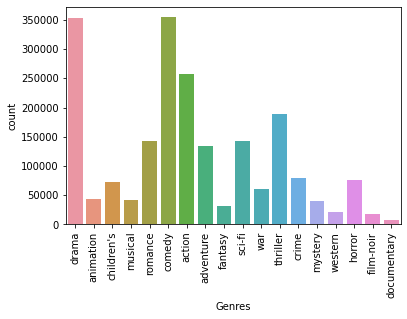

In [ ]:
sns.countplot(data=genres_explore,x='Genres')
plt.xticks(rotation=90)

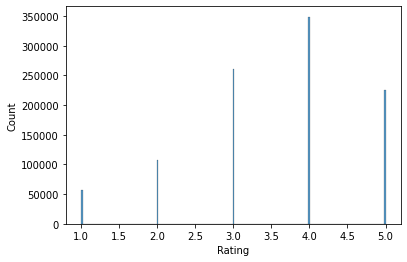

In [ ]:
sns.histplot(data=ratings,x='Rating')

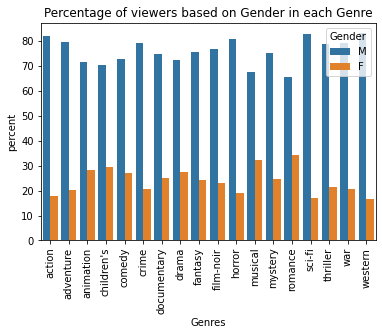

In [ ]:
sns.barplot(data=genres_explore.groupby('Genres')['Gender']
              .value_counts(normalize=True).mul(100).rename('percent')
              .reset_index(),x='Genres',y='percent',hue='Gender')
plt.xticks(rotation=90)
plt.title('Percentage of viewers based on Gender in each Genre')
plt.show()


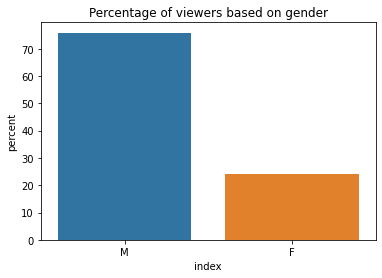

In [ ]:
sns.barplot(data=genres_explore.Gender.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on gender')
plt.show()

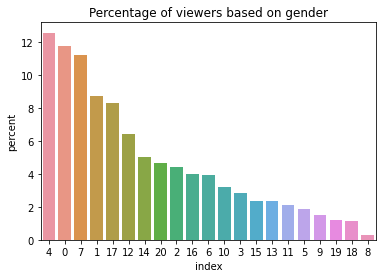

In [ ]:
sns.barplot(data=users.Occupation.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on gender')
plt.show()

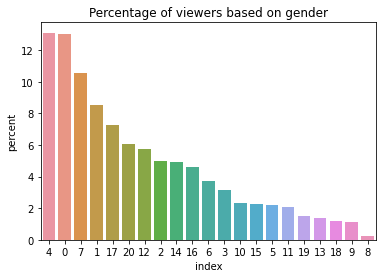

In [ ]:
sns.barplot(data=rum_merge.Occupation.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on gender')
plt.show()

### Item-based approach

#### 1.Pearson Correlation

In [ ]:
item = movies.copy()
#creating genres based data by exploding genres column 

def preprocess_str(x):
  return x.lower().strip()
item['Genres'] = item['Genres'].apply(lambda x: preprocess_str(str(x)))
item['Genres'] = item['Genres'].str.split('|')
item = item.explode('Genres').reset_index()

#replacing mistype genres
dic = {'comedy':['come','comed','com'],
'thriller':['thri','thrille','th'],
'romance':['rom','ro','roma','roman','r'],
'documentary':['docu','documen','document','documenta'],
'western':['wester','we'],
'sci-fi': ['sci','sci-','sci-f','s'],
'drama': ['dram','dr','d'],
'horror':['horro','horr'],
'children\'s':['children\'','childr','chil','chi','children','childre'],
'action':['acti','a'],
'animation':['animati'],
'adventure':['advent','adventur','adventu','adv'],
'war':['wa'],
'fantasy':['fantas','f','fant'],
'musical':['music']}

for i in dic:
  for j in dic[i]:
    item.Genres=item.Genres.replace(j,i)
item = item[item.Genres!='']

item = pd.merge(item, ratings.groupby('MovieID')['Rating'].mean().reset_index(), on=['MovieID'],how='left')
item.fillna(0,inplace=True)

item_m = item.groupby(['MovieID','Genres'])['Rating'].mean().reset_index().pivot(index='MovieID',columns='Genres',values='Rating')
item_m = ~item_m.isna()
item_m = item_m.astype(int)


In [ ]:
m_list = item_m.index
arr_item_m = np.array(item_m.reset_index().drop(columns=['MovieID']))

from scipy.stats import pearsonr
i_i_pear_sim = []

for i in range(3883):
    for j in range(i+1,3883):
        i_i_pear_sim.append([m_list[i], m_list[j], round(pearsonr(arr_item_m[i] ,arr_item_m[j])[0],3)])

back_up_i_i_pear_sim = i_i_pear_sim.copy()
# back_up_i_i_pear_sim.to_csv('back_up_i_i_pear_sim.csv')

i_i_pear_sim = pd.DataFrame(i_i_pear_sim, columns=['movie', 'rec_movie', 'pear_similarity'])
i_i_pear_sim = i_i_pear_sim.merge(movies[['MovieID', 'Title']], left_on='movie', 
                              right_on='MovieID').rename(columns={'Title': 'movie_title'}).drop(columns=['MovieID'])
i_i_pear_sim = i_i_pear_sim.merge(movies[['MovieID', 'Title']], left_on='rec_movie', 
                              right_on='MovieID').rename(columns={'Title': 'rec_movie_title'}).drop(columns=['MovieID'])

dope_ = i_i_pear_sim.copy()

dope_.columns = [ 'rec_movie','movie', 'pear_similarity', 'rec_movie_title', 'movie_title']

i_i_pear_sim = pd.concat([i_i_pear_sim, dope_], axis=0)

i_i_pear_sim.reset_index().drop(columns='index')

i_i_pear_sim = i_i_pear_sim.merge(ratings.groupby('MovieID').size().reset_index(),left_on='rec_movie',right_on='MovieID')

i_i_pear_sim.rename(columns={0:'no_of_ratings'},inplace=True)

i_i_pear_sim = i_i_pear_sim.sort_values(by=['movie','pear_similarity','no_of_ratings'],ascending=[True,False,False])


In [ ]:
# i_i_pear_sim = pd.read_csv('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/back_up_i_i_pear_sim.csv')
# i_i_pear_sim.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
pear_movies = movies.copy()
pear_movies['movie'] = pear_movies.Title.apply(lambda x : str(x)[:-7])
pear_movies['MovieID'] = pear_movies['MovieID'].astype(int)

def pearson_item_item_similarity(movie, no_of_rec):
  if movie in list(pear_movies['movie']):
    id = pear_movies[pear_movies['movie']==movie]['MovieID'].values
    return i_i_pear_sim[i_i_pear_sim['movie']==id[0]].iloc[:no_of_rec,:]
  return 'There is no such movie'

In [ ]:
pearson_item_item_similarity('Toy Story',5)

,movie,rec_movie,pear_similarity,movie_title,rec_movie_title,MovieID,no_of_ratings
11646,1,2355,1.0,Toy Story (1995),"Bug's Life, A (1998)",2355,1703
15528,1,3114,1.0,Toy Story (1995),Toy Story 2 (1999),3114,1585
23292,1,3751,1.0,Toy Story (1995),Chicken Run (2000),3751,1329
3882,1,2141,1.0,Toy Story (1995),"American Tail, An (1986)",2141,404
0,1,1064,1.0,Toy Story (1995),Aladdin and the King of Thieves (1996),1064,209


#### 2.Cosine Similarity

#### Item Cosine Similarity

In [ ]:
item = movies.copy()
#creating genres based data by exploding genres column 

def preprocess_str(x):
  return x.lower().strip()
item['Genres'] = item['Genres'].apply(lambda x: preprocess_str(str(x)))
item['Genres'] = item['Genres'].str.split('|')
item = item.explode('Genres').reset_index()

#replacing mistype genres
dic = {'comedy':['come','comed','com'],
'thriller':['thri','thrille','th'],
'romance':['rom','ro','roma','roman','r'],
'documentary':['docu','documen','document','documenta'],
'western':['wester','we'],
'sci-fi': ['sci','sci-','sci-f','s'],
'drama': ['dram','dr','d'],
'horror':['horro','horr'],
'children\'s':['children\'','childr','chil','chi','children','childre'],
'action':['acti','a'],
'animation':['animati'],
'adventure':['advent','adventur','adventu','adv'],
'war':['wa'],
'fantasy':['fantas','f','fant'],
'musical':['music']}

for i in dic:
  for j in dic[i]:
    item.Genres=item.Genres.replace(j,i)
item = item[item.Genres!='']

item = pd.merge(item, ratings.groupby('MovieID')['Rating'].mean().reset_index(), on=['MovieID'],how='left')
item.fillna(0,inplace=True)

item_m = item.groupby(['MovieID','Genres'])['Rating'].mean().reset_index().pivot(index='MovieID',columns='Genres',values='Rating')
item_m = ~item_m.isna()
item_m = item_m.astype(int)


In [ ]:
m_list = item_m.index
arr_item_m = np.array(item_m.reset_index().drop(columns=['MovieID']))

from sklearn.metrics.pairwise import cosine_similarity
i_i_cos_sim = []

for i in range(3883):
    for j in range(i+1,3883):
        i_i_cos_sim.append([m_list[i], m_list[j], round(cosine_similarity(np.array([arr_item_m[i]]) , np.array([arr_item_m[j]]))[0,0],3)])

back_up_i_i_cos_sim = i_i_cos_sim.copy()
# back_up_i_i_cos_sim.to_csv('back_up_i_i_cos_sim.csv')

i_i_cos_sim = pd.DataFrame(i_i_cos_sim, columns=['movie', 'rec_movie', 'cos_similarity'])
i_i_cos_sim = i_i_cos_sim.merge(movies[['MovieID', 'Title']], left_on='movie', 
                              right_on='MovieID').rename(columns={'Title': 'movie_title'}).drop(columns=['MovieID'])
i_i_cos_sim = i_i_cos_sim.merge(movies[['MovieID', 'Title']], left_on='rec_movie', 
                              right_on='MovieID').rename(columns={'Title': 'rec_movie_title'}).drop(columns=['MovieID'])

dope_ = i_i_cos_sim.copy()

dope_.columns = [ 'rec_movie','movie', 'cos_similarity', 'rec_movie_title', 'movie_title']

i_i_cos_sim = pd.concat([i_i_cos_sim, dope_], axis=0)

i_i_cos_sim.reset_index().drop(columns='index')

i_i_cos_sim = i_i_cos_sim.merge(ratings.groupby('MovieID').size().reset_index(),left_on='rec_movie',right_on='MovieID')

i_i_cos_sim.rename(columns={0:'no_of_ratings'},inplace=True)

i_i_cos_sim = i_i_cos_sim.sort_values(by=['movie','cos_similarity','no_of_ratings'],ascending=[True,False,False])
i_i_cos_sim.drop(columns='MovieID',inplace=True)

In [ ]:
# i_i_cos_sim = pd.read_csv('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/back_up_i_i_cos_sim.csv')
# i_i_cos_sim.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
pear_movies = movies.copy()
pear_movies['movie'] = pear_movies.Title.apply(lambda x : str(x)[:-7])
pear_movies['MovieID'] = pear_movies['MovieID'].astype(int)

def cosine_item_item_similarity(movie, no_of_rec):
  if movie in list(pear_movies['movie']):
    id = pear_movies[pear_movies['movie']==movie]['MovieID'].values
    return i_i_cos_sim[i_i_cos_sim['movie']==id[0]].iloc[:no_of_rec,:]
  return 'There is no such movie'

In [ ]:
cosine_item_item_similarity('Liar Liar',5)

,movie,rec_movie,cos_similarity,movie_title,rec_movie_title,no_of_ratings
10808943,1485,2997,1.0,Liar Liar (1997),Being John Malkovich (1999),2241
10036425,1485,2791,1.0,Liar Liar (1997),Airplane! (1980),1731
4108610,1485,1136,1.0,Liar Liar (1997),Monty Python and the Holy Grail (1974),1599
9314373,1485,2599,1.0,Liar Liar (1997),Election (1999),1522
10517793,1485,2918,1.0,Liar Liar (1997),Ferris Bueller's Day Off (1986),1473


In [ ]:
i_i_similarity_matrix = i_i_cos_sim.pivot(index='movie',columns='rec_movie',values='cos_similarity').fillna(1.0)

In [ ]:
i_i_similarity_matrix.head()

rec_movie,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie,,,,,,,,,,,,,,,,,,,,,
1,1.000,0.333,0.408,0.408,0.577,0.0,0.408,0.408,0.0,0.000,...,0.577,0.408,0.667,0.000,0.0,0.577,0.000,0.000,0.000,0.0
2,0.333,1.000,0.000,0.000,0.000,0.0,0.000,0.816,0.0,0.333,...,0.000,0.000,0.667,0.000,0.0,0.000,0.000,0.000,0.000,0.0
3,0.408,0.000,1.000,0.500,0.707,0.0,1.000,0.000,0.0,0.000,...,0.707,0.500,0.000,0.000,0.0,0.707,0.000,0.000,0.000,0.0
4,0.408,0.000,0.500,1.000,0.707,0.0,0.500,0.000,0.0,0.000,...,0.707,1.000,0.000,0.408,0.0,0.707,0.707,0.707,0.707,0.5
5,0.577,0.000,0.707,0.707,1.000,0.0,0.707,0.000,0.0,0.000,...,1.000,0.707,0.000,0.000,0.0,1.000,0.000,0.000,0.000,0.0


#### User Cosine Similarit

In [ ]:
ratings['hour'] = ratings.Timestamp.apply(lambda x: pd.Timestamp.fromtimestamp(int(x)).hour)

users = user.copy()
users['Occupation'] = users['Occupation'].astype('int')
users['Age'] = users['Age'].astype('int')
users['UserID'] = users['UserID'].astype('int')

dic_age = {1:1,18:2,25:3,35:4,45:5,50:6,56:7}
users.Age = users.Age.map(dic_age)
users.Gender = users.Gender.map({'F':0,'M':1})

users = users.merge(ratings.groupby('UserID').Rating.mean().reset_index(),on='UserID')
users = users.merge(ratings.groupby('UserID').hour.median().reset_index(),on='UserID')
users = users.merge(ratings.groupby('UserID').size().reset_index(),on='UserID')

u = users.copy()
u = u[['UserID','Gender', 'Age','Rating', 'hour',0]]
u = u.set_index('UserID')
u.rename(columns={0:'no_of_ratings'},inplace=True)

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
user_m = pd.DataFrame(ss.fit_transform(u), columns=u.columns,index=u.index)


In [ ]:
u_list = u.index
arr_item_u =  np.array(u.reset_index().drop(columns=['UserID']))

from sklearn.metrics.pairwise import cosine_similarity
u_u_cos_sim = []

for i in range(6040):
    for j in range(i+1,6040):
        u_u_cos_sim.append([u_list[i], u_list[j], round(cosine_similarity(np.array([arr_item_u[i]]) , np.array([arr_item_u[j]]))[0,0],3)])

back_up_u_u_cos_sim = u_u_cos_sim.copy()

u_u_cos_sim = pd.DataFrame(u_u_cos_sim, columns=['user', 'sim_user', 'cos_similarity'])

u_u_cos_sim = u_u_cos_sim.merge(users[['UserID', 'Gender']], left_on='user', 
                              right_on='UserID').rename(columns={'Gender': 'user_Gender'}).drop(columns=['UserID'])
u_u_cos_sim = u_u_cos_sim.merge(users[['UserID', 'Gender','Age','Rating', 'hour']], left_on='sim_user', 
                              right_on='UserID').rename(columns={'Gender': 'sim_user_Gender'}).drop(columns=['UserID'])


dope_ = u_u_cos_sim.copy()

dope_.columns = [ 'sim_user','user', 'cos_similarity', 'sim_user_Gender', 'user_Gender']

u_u_cos_sim = pd.concat([u_u_cos_sim, dope_], axis=0)

u_u_cos_sim.reset_index().drop(columns='index')

u_u_cos_sim = u_u_cos_sim.sort_values(by=['user','cos_similarity','sim_user'],ascending=[True,False,True])
u_u_cos_sim.head()

In [ ]:
# u_u_cos_sim = pd.read_csv('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/back_up_u_u_cos_sim.csv')
# u_u_cos_sim.drop(columns='Unnamed: 0',inplace=True)

In [ ]:

def cosine_user_user_similarity(userid, no_of_rec):
  df = u_u_cos_sim[u_u_cos_sim['user']==userid].iloc[:no_of_rec,:]
  df = df.merge(users[['UserID', 'Age', 'Rating','hour','Occupation','Zip-code' ]], left_on='user', 
                              right_on='UserID').rename(columns={'Age':'user_Age', 'Rating':'user_Rating','hour':'user_hour',
                                                                 'Occupation':'user_Occupation','Zip-code':'user_Zip-code'}).drop(columns=['UserID'])
  df = df.merge(users[['UserID', 'Age', 'Rating','hour','Occupation','Zip-code']], left_on='sim_user', 
                              right_on='UserID').rename(columns={'Age':'sim_user_Age', 'Rating':'sim_user_Rating','hour':'sim_user_hour',
                                                         'Occupation':'sim_user_Occupation','Zip-code':'sim_user_Zip-code'}).drop(columns=['UserID'])
  return df



In [ ]:
cosine_user_user_similarity(2,5)

,user,sim_user,cos_similarity,user_Gender,sim_user_Gender,user_Age,user_Rating,user_hour,user_Occupation,user_Zip-code,sim_user_Age,sim_user_Rating,sim_user_hour,sim_user_Occupation,sim_user_Zip-code
0,2,31,0.999,1,1,7,3.713178,21.0,16,70072,7,3.731092,20.0,7,06840
1,2,2025,0.998,1,1,7,3.713178,21.0,16,70072,7,3.680672,22.0,13,03440
2,2,1016,0.996,1,1,7,3.713178,21.0,16,70072,7,3.788079,20.0,16,60044
3,2,3364,0.996,1,1,7,3.713178,21.0,16,70072,7,3.625000,21.0,13,17033
4,2,2661,0.994,1,1,7,3.713178,21.0,16,70072,7,3.612245,22.0,13,19312


In [ ]:
u_u_similarity_matrix = u_u_cos_sim.pivot(index='user',columns='sim_user',values='cos_similarity').fillna(1.0)

In [ ]:
u_u_similarity_matrix.head()

sim_user,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user,,,,,,,,,,,,,,,,,,,,,
1,1.000,-0.435,0.439,0.065,-0.562,-0.098,-0.142,-0.293,-0.371,0.106,...,0.425,-0.487,-0.708,-0.103,-0.176,-0.125,-0.118,-0.251,0.470,-0.228
2,-0.435,1.000,0.215,0.715,-0.338,0.222,-0.037,-0.484,-0.489,-0.314,...,-0.768,0.222,0.406,-0.383,-0.421,-0.362,-0.076,0.334,0.441,-0.140
3,0.439,0.215,1.000,0.675,-0.390,-0.585,0.012,-0.260,-0.327,-0.711,...,-0.460,-0.240,-0.389,-0.061,-0.753,-0.726,-0.840,-0.583,0.142,0.082
4,0.065,0.715,0.675,1.000,-0.690,0.057,0.377,-0.224,-0.332,-0.364,...,-0.608,0.343,0.258,0.042,-0.893,-0.737,-0.343,0.091,0.393,-0.304
5,-0.562,-0.338,-0.390,-0.690,1.000,-0.345,-0.214,0.384,0.551,-0.251,...,0.120,-0.107,0.085,0.115,0.638,0.273,-0.094,-0.246,-0.761,0.431


### Matrix Factorization

In [ ]:
#creating pivot tables of users items ratings
r_m_p = ratings.pivot(index='UserID',columns='MovieID',values='Rating').fillna(0)

#creating dataframe that  fit to CMF
rating_m = ratings[['UserID', 'MovieID', 'Rating']].copy()
rating_m.columns = ['UserId', 'ItemId', 'Rating']

In [ ]:
!pip install cmfrec
from cmfrec import CMF

model = CMF(k=4, verbose=False)
model.fit(rating_m)

In [ ]:
#predicting ratings of each movie by each user
r_m = np.dot(model.A_, model.B_.T) + model.glob_mean_

In [ ]:
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape 

print("RMSE = ",mse(r_m_p.values[r_m_p>0], r_m[r_m_p>0])**0.5)
print('MAPE = ',mape(r_m_p.values[r_m_p>0], r_m[r_m_p>0])**0.5)

RMSE =  1.1453975366544094
MAPE =  0.6185346760348142


In [ ]:
#user movie recommendations of rating prediction
r_m_df = pd.DataFrame(r_m, index=r_m_p.index,columns=r_m_p.columns)
r_m_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,3.542758,3.311654,3.764914,3.863533,3.547580,3.295339,3.885130,3.743552,3.917815,3.852580,...,3.593877,3.554674,3.583766,3.582542,3.582765,3.617747,3.577395,3.545493,3.586379,3.579847
2,3.538883,3.414415,4.082417,4.153300,3.862930,3.558670,4.052127,3.680668,4.067194,4.012268,...,3.600920,3.539292,3.594631,3.581724,3.579767,3.579874,3.571558,3.590107,3.628207,3.574353
3,3.302437,3.325895,3.533631,3.676925,3.487297,3.481897,3.575868,3.498687,3.463849,3.458061,...,3.564308,3.619252,3.582665,3.581757,3.583046,3.566123,3.582461,3.523398,3.597467,3.575206
4,3.758808,3.623648,3.760372,3.686148,3.604316,3.447697,3.719918,3.724356,3.901928,3.861301,...,3.604947,3.530497,3.582765,3.582083,3.581545,3.617560,3.579405,3.610178,3.570249,3.585533
5,3.896356,4.059308,3.236124,2.939977,3.338275,3.620658,2.991172,3.521703,3.310800,3.356354,...,3.589267,3.564743,3.569753,3.581374,3.582678,3.605389,3.593169,3.655183,3.513581,3.595928


### Embeddings for item-item and user-user similarity

#### item-item

In [ ]:
emb_i_i_m = pd.DataFrame(model.B_,index=r_m_p.columns,columns=['f1','f2','f3','f4'])

In [ ]:
m_list = emb_i_i_m.index
arr_item_m = np.array(emb_i_i_m.reset_index().drop(columns=['MovieID']))

from sklearn.metrics.pairwise import cosine_similarity
emb_ii_cos_sim = []

for i in range(3706):
    for j in range(i+1,3706):
        emb_ii_cos_sim.append([m_list[i], m_list[j], round(cosine_similarity(np.array([arr_item_m[i]]) , np.array([arr_item_m[j]]))[0,0],3)])

back_up_emb_ii_cos_sim = emb_ii_cos_sim.copy()
# back_up_emb_ii_cos_sim.to_csv('back_up_emb_ii_cos_sim.csv')

emb_ii_cos_sim = pd.DataFrame(emb_ii_cos_sim, columns=['movie', 'rec_movie', 'cos_similarity'])
emb_ii_cos_sim = emb_ii_cos_sim.merge(movies[['MovieID', 'Title']], left_on='movie', 
                              right_on='MovieID').rename(columns={'Title': 'movie_title'}).drop(columns=['MovieID'])
emb_ii_cos_sim = emb_ii_cos_sim.merge(movies[['MovieID', 'Title']], left_on='rec_movie', 
                              right_on='MovieID').rename(columns={'Title': 'rec_movie_title'}).drop(columns=['MovieID'])

dope_ = emb_ii_cos_sim.copy()

dope_.columns = [ 'rec_movie','movie', 'cos_similarity', 'rec_movie_title', 'movie_title']

emb_ii_cos_sim = pd.concat([emb_ii_cos_sim, dope_], axis=0)

emb_ii_cos_sim.reset_index().drop(columns='index')

emb_ii_cos_sim = emb_ii_cos_sim.sort_values(by=['movie','cos_similarity','rec_movie'],ascending=[True,False,True])
emb_ii_cos_sim.head()

In [ ]:
# emb_ii_cos_sim = pd.read_csv('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/emb_ii_df.csv')

In [ ]:
emb_ii_cos_sim.pivot(index='movie',columns='rec_movie',values='cos_similarity').fillna(1)

rec_movie,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie,,,,,,,,,,,,,,,,,,,,,
1,1.000,0.550,0.058,-0.022,0.646,0.408,0.641,0.802,0.367,0.428,...,0.864,-0.150,0.728,0.871,0.873,0.725,0.782,0.662,0.261,0.940
2,0.550,1.000,-0.158,-0.435,0.457,0.752,-0.139,-0.055,-0.257,-0.181,...,0.345,0.198,0.513,0.542,0.549,-0.102,0.761,0.862,0.211,0.607
3,0.058,-0.158,1.000,0.920,0.377,-0.234,0.434,0.219,0.853,0.858,...,0.551,-0.789,0.332,-0.040,-0.091,0.192,-0.347,0.344,0.411,-0.132
4,-0.022,-0.435,0.920,1.000,0.390,-0.275,0.605,0.325,0.831,0.826,...,0.457,-0.632,0.326,-0.007,-0.056,0.221,-0.390,0.065,0.508,-0.148
5,0.646,0.457,0.377,0.390,1.000,0.719,0.712,0.486,0.325,0.407,...,0.717,0.049,0.993,0.856,0.829,0.181,0.676,0.686,0.901,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.725,-0.102,0.192,0.221,0.181,-0.304,0.684,0.926,0.669,0.667,...,0.729,-0.518,0.253,0.424,0.425,1.000,0.200,0.122,-0.145,0.520
3949,0.782,0.761,-0.347,-0.390,0.676,0.844,0.334,0.394,-0.224,-0.143,...,0.462,0.455,0.736,0.910,0.925,0.200,1.000,0.620,0.421,0.932
3950,0.662,0.862,0.344,0.065,0.686,0.607,0.205,0.195,0.241,0.320,...,0.696,-0.216,0.724,0.597,0.579,0.122,0.620,1.000,0.432,0.617


#### user-user

In [ ]:
emb_u_u_m = pd.DataFrame(model.A_,index=r_m_p.index,columns=['f1','f2','f3','f4'])

In [ ]:
u_list = emb_u_u_m.index
arr_item_u =  np.array(emb_u_u_m.reset_index().drop(columns=['UserID']))

from sklearn.metrics.pairwise import cosine_similarity
emb_uu_cos_sim = []

for i in range(6040):
    for j in range(i+1,6040):
        emb_uu_cos_sim.append([u_list[i], u_list[j], round(cosine_similarity(np.array([arr_item_u[i]]) , np.array([arr_item_u[j]]))[0,0],3)])

back_up_emb_uu_cos_sim = emb_uu_cos_sim.copy()

emb_uu_cos_sim = pd.DataFrame(emb_uu_cos_sim, columns=['user', 'sim_user', 'cos_similarity'])

emb_uu_cos_sim = emb_uu_cos_sim.merge(users[['UserID', 'Gender']], left_on='user', 
                              right_on='UserID').rename(columns={'Gender': 'user_Gender'}).drop(columns=['UserID'])
emb_uu_cos_sim = emb_uu_cos_sim.merge(users[['UserID', 'Gender','Age','Rating', 'hour']], left_on='sim_user', 
                              right_on='UserID').rename(columns={'Gender': 'sim_user_Gender'}).drop(columns=['UserID'])


dope_ = emb_uu_cos_sim.copy()

dope_.columns = [ 'sim_user','user', 'cos_similarity', 'sim_user_Gender', 'user_Gender']

emb_uu_cos_sim = pd.concat([emb_uu_cos_sim, dope_], axis=0)

emb_uu_cos_sim.reset_index().drop(columns='index')

emb_uu_cos_sim = emb_uu_cos_sim.sort_values(by=['user','cos_similarity','sim_user'],ascending=[True,False,True])
emb_uu_cos_sim.head()

In [ ]:
# emb_uu_cos_sim = pd.read_csv('/content/drive/MyDrive/Projects Notebooks/Zee_Recommender_Systems/emb_uu_df.csv')

In [ ]:
emb_uu_cos_sim.pivot(index='user',columns='sim_user',values='cos_similarity').fillna(1.0)

sim_user,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user,,,,,,,,,,,,,,,,,,,,,
1,1.000,0.592,0.447,0.681,-0.565,0.471,0.218,-0.025,0.086,-0.154,...,0.188,-0.788,0.164,-0.199,-0.863,-0.099,0.863,-0.361,0.094,-0.310
2,0.592,1.000,0.324,0.312,-0.867,0.545,0.111,-0.470,-0.127,0.373,...,0.510,-0.295,0.833,-0.557,-0.157,-0.238,0.299,0.292,0.671,-0.332
3,0.447,0.324,1.000,-0.266,-0.585,0.701,0.693,-0.190,-0.142,0.502,...,0.876,-0.776,0.437,-0.486,-0.550,-0.925,-0.019,0.055,0.376,-0.849
4,0.681,0.312,-0.266,1.000,0.025,0.177,-0.524,-0.145,-0.140,-0.350,...,-0.446,-0.142,-0.139,0.430,-0.541,0.575,0.885,-0.200,-0.020,0.483
5,-0.565,-0.867,-0.585,0.025,1.000,-0.414,-0.589,0.131,-0.204,-0.278,...,-0.687,0.576,-0.737,0.868,0.222,0.518,-0.180,-0.021,-0.447,0.738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.099,-0.238,-0.925,0.575,0.518,-0.617,-0.678,0.263,0.203,-0.679,...,-0.950,0.513,-0.539,0.541,0.200,1.000,0.392,-0.277,-0.472,0.837
6037,0.863,0.299,-0.019,0.885,-0.180,0.087,-0.088,0.201,0.221,-0.546,...,-0.334,-0.526,-0.244,0.137,-0.763,0.392,1.000,-0.565,-0.260,0.112
6038,-0.361,0.292,0.055,-0.200,-0.021,0.554,-0.436,-0.912,-0.837,0.889,...,0.433,0.524,0.690,0.126,0.461,-0.277,-0.565,1.000,0.874,0.186


### Questionnaire:

##### 1. Users of which age group have watched and rated the most number of movies?

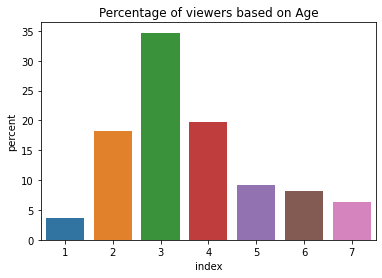

In [ ]:
sns.barplot(data=users.Age.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on Age')
plt.show()

**25-34 age group have watched and rated the most number of movies**

##### 2. Users belonging to which profession have watched and rated the most movies?


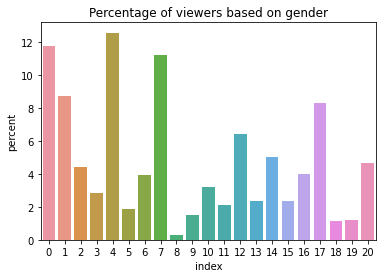

In [ ]:
sns.barplot(data=users.Occupation.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on gender')
plt.show()

**college/grad student profession have watched and rated the most movies**

##### 3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)

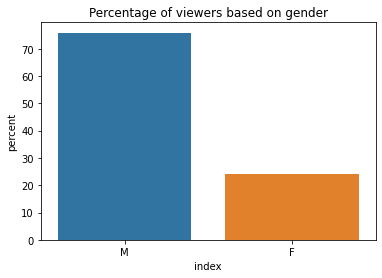

In [ ]:
sns.barplot(data=genres_explore.Gender.value_counts(normalize=True).mul(100).rename('percent').reset_index(),x='index',y='percent')
plt.title('Percentage of viewers based on gender')
plt.show()

**TRUE 75% of total ratings came from male**

##### 4. Most of the movies present in our dataset were released in which decade?
* a. 70s b. 90s c. 50s d.80s


In [ ]:
bin_movies = movies.copy()
bins = [0, 1949, 1959,1969,1979,1989,1999, 2009]
bin_movies['bins'] = pd.cut(bin_movies['release_year'],bins)

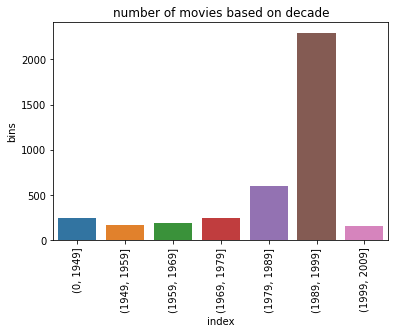

In [ ]:
sns.barplot(data=bin_movies.bins.value_counts().reset_index(),x='index',y='bins')
plt.title('number of movies based on decade')
plt.xticks(rotation=90)
plt.show()

**b. 90's there are most of the movies present**

##### 5. The movie with maximum no. of ratings is ___.

In [ ]:
ratings.MovieID.value_counts()[:3]

2858    3428
260     2991
1196    2990
Name: MovieID, dtype: int64

In [ ]:
movies[movies['MovieID']==2858]

,MovieID,Title,Genres,release_year
2789,2858,American Beauty (1999),Comedy|Drama,1999


**The movie with maximum no. of ratings is American Beauty (1999)**

##### 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [ ]:
cosine_item_item_similarity('Liar Liar',3)

,movie,rec_movie,cos_similarity,movie_title,rec_movie_title,no_of_ratings
10808943,1485,2997,1.0,Liar Liar (1997),Being John Malkovich (1999),2241
10036425,1485,2791,1.0,Liar Liar (1997),Airplane! (1980),1731
4108610,1485,1136,1.0,Liar Liar (1997),Monty Python and the Holy Grail (1974),1599


##### 7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

**Collaborative Filtering methods can be classified into user-based and item-based.**

##### 8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

Pearson Correlation ranges between -1 to 1. whereas, Cosine Similarity belongs to the interval between -1 and 1.

##### 9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

In [ ]:
print("RMSE = ",mse(r_m_p.values[r_m_p>0], r_m[r_m_p>0])**0.5)
print('MAPE = ',mape(r_m_p.values[r_m_p>0], r_m[r_m_p>0])**0.5)

RMSE =  1.1453975366544094
MAPE =  0.6185346760348142


##### 10. Give the sparse ‘row’ matrix representation for the following dense matrix - [[1 0],[3 7]]

[0, 1, 1]